In [215]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
%matplotlib inline

PREPROCESS = False
AUGMENT = False
# leadboard: https://www.sbert.net/docs/pretrained_models.html#model-overview
model_for_embeddings = "all-mpnet-base-v2"

if PREPROCESS and AUGMENT:
    orig_csv_save_name = "data_with_all_embeddings_preprocess_aug"
    ann_csv_save_name = "ann_data_with_preprocess_aug"
elif PREPROCESS:
    orig_csv_save_name = "data_with_all_embeddings_preprocessg"
    ann_csv_save_name = "ann_data_with_preprocess"
elif AUGMENT:
    orig_csv_save_name = "data_with_all_embeddings_aug"
    ann_csv_save_name = "ann_data_with_aug"
else:
    orig_csv_save_name = "data_with_all_embeddings"
    ann_csv_save_name = "ann_data"

In [216]:
sns.set_style("darkgrid")
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [217]:
data = pd.read_csv("../data/data.csv")

In [218]:
data.head()

,Customer,Type,Text,Summary
0,Notion,Appstore/Playstore,User: The app doesn't send sound or vibration ...,User finds the app useless without sound or vi...
1,Notion,Appstore/Playstore,"User: This app changed my life, I can only say...","User praises the app, stating it has changed t..."
2,Notion,Appstore/Playstore,User: Have you ever experienced this situation...,NaN
3,Notion,Appstore/Playstore,User: Mass editing a table/database is so slow...,User finds Notion's mass editing feature slow ...
4,Notion,Appstore/Playstore,User: the only concern is that it doesn't work...,User is concerned about the product not workin...


In [219]:
data.shape

(5009, 4)

In [220]:
data.isna().sum()

Customer       0
Type           0
Text           0
Summary     1008
dtype: int64

In [221]:
print(data[data['Summary'].isna()]['Summary'])

2       NaN
8       NaN
15      NaN
17      NaN
18      NaN
       ... 
5004    NaN
5005    NaN
5006    NaN
5007    NaN
5008    NaN
Name: Summary, Length: 1008, dtype: object


In [222]:
# we want even such samples in training. So replace Summary with "None"
data['Summary'].fillna("Nothing", inplace = True)

In [223]:
data.isna().sum()

Customer    0
Type        0
Text        0
Summary     0
dtype: int64

In [224]:
data['text_length'] = data['Text'].apply(lambda text: len(text.split()))
data['summary_length'] = data['Summary'].apply(lambda summary: len(summary.split()))
data['sum_text_ratio'] = data['summary_length'] / data['text_length']

Text(0.5, 1.0, 'Ratio of summary to text length')

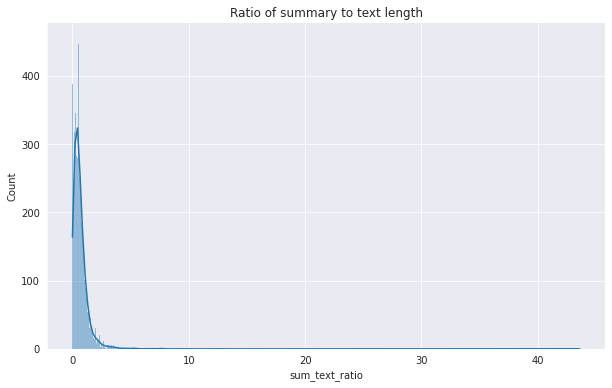

In [225]:
# some summaries are larger than the text
sns.histplot(data['sum_text_ratio'], kde = True)
plt.title("Ratio of summary to text length")

In [226]:
print("Original Text: ", data[data['sum_text_ratio'] > 10].reset_index(drop = True)['Text'][0])
print("Summary: ", data[data['sum_text_ratio'] > 10].reset_index(drop = True)['Summary'][0])

Original Text:  User: Pretty! 💙
@browsercompany <STRICT_LINK>
Summary:  User: I'm not sure if I'm the only one who's having this issue, but I'm having a problem with the browserco app. I can't get it to open. I've tried restarting my phone, restarting the app, and even restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app 

In [227]:
print(data[data['sum_text_ratio'] > 5].index)

Index([ 753, 1957, 1959, 2013, 2036, 2074, 2175, 2186, 2187, 2231, 2254, 2390,
       2546, 2694, 2698, 2942, 3112, 3375, 3382, 3706, 3799],
      dtype='int64')


In [228]:
# Some examples: 

# // Need to extract only summary from such examples. 
# // Summary is irrelevant to the Text
# Text: User: Where is the Arabic language thanks 
# Summary:  
# Product: Notion
# Feedbacktype: RecordTypeReview
# Review Content: User: I love it
# Summary:
# User loves the product.

# // Summary is irrelevant to the Text
# Text: User: Spanish - Spanish
# Summary: 
# Review Content: User: I love it
# Summary:
# User loves the product.

# Text: User: 123
# Summary:
# Review Content: User: 123
# Summary:
#  None

# // Different language
# Text: User: iPhoneとiPadだと日本語でタイトル入力すると消える！
# Summary: User experiences issues with the app on iPhone and iPad, where the title input disappears when using Japanese.

# // Twitter content that cant be inferred without strict link
# Text: User: This week's @NotionHQ content is brought to you by: matcha <STRICT_LINK>
# Summary: User shares a link to a Notion article about the importance of a good night's sleep and mentions that they are going to try out the Notion app.

# Text: User: .@NotionHQ kidding? <STRICT_LINK>
# Summary: User is excited about the new Notion app and is looking forward to using it.

# // Couple of words expanded to sentence in summary
# Text: User: Network issue
# Summary: User experienced network issues while using Zoom.


# Upon browsing twitter text, it seems like the summary of twitter text is the most unobvious. Sometimes can't even be summarized without knowing the content of Strict_Link

In [229]:
# preprocess text to remove strict_links and emojis. 
# Don't remove @ and # because the user might have tweeted as: Good feature by @Enterpret, @Notion always crash. Here without mentions, it would be impossible to know the good review is for which product and the bad review for which
# Dont remove hastag because some people tweet: #excited #lovedit etc. which can help know the intent of review

def preprocess_text(text):

    # Remove strict links
    text = re.sub(r'https?:\/\/\S+', '', text)

    # Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251" 
        "]+"
    )
    text = emoji_pattern.sub('', text)

    # Remove any remaining special characters or punctuations
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace("STRICT_LINK", "")

    return text

In [230]:
example = data[data['Type'] == "Twitter"]['Text'][997]
processed_text = preprocess_text(example)
print("Original text: ", example)
print("Processed text: ", processed_text)

Original text:  User: This week's @NotionHQ content is brought to you by: matcha <STRICT_LINK>
Processed text:  User This weeks NotionHQ content is brought to you by matcha 


In [231]:
# apply on Text
if PREPROCESS:
    data['Text'] = data['Text'].apply(preprocess_text)

In [232]:
# lets look at some "None" summaries

# Following is `Help` or `Complained` category
# 'User: Have you ever experienced this situation? The payment interface still pops up when you subscribe and then use it'

# `Help` category
# 'User: I HAD SUCH A LONG NOTION PAGES AND MY ACC GOT REMOVED FOR WHAT???? HELP'

# `Praise` category
# 'User: The only place to put your “Notes-On”'

# `Praise` category
# 'User: Best app...'

# We may remove it from the first iteration of training, then predict on them with the first trained model and use it for training again

# thats a significant about of None content
len(data[data['Summary'] == "Nothing"])

# Observed that if the Text is very concise < 3-4 words and is a positive review, then Summary is "None". THey should have been summarised under the `Praise` intent

1008

In [233]:
# lets see if some summary is repeated multiple times

data['Summary'].value_counts().head(5)

Summary
Nothing                                                                                                                                                       1008
User is excited about the new Notion app and is looking forward to using it.                                                                                   274
User is excited about the new features in Notion and is looking forward to using them.                                                                          37
\n None                                                                                                                                                         36
User is excited about the new features in the latest version of BrowserCO, including the ability to add a custom logo and customize the color of the logo.      31
Name: count, dtype: int64

In [234]:
# replace `\n None` with `None`
data['Summary'] = data['Summary'].replace("\n None", "Nothing")

In [235]:
data['Summary'].value_counts().head(5)

Summary
Nothing                                                                                                                                                       1044
User is excited about the new Notion app and is looking forward to using it.                                                                                   274
User is excited about the new features in Notion and is looking forward to using them.                                                                          37
User is excited about the new features in the latest version of BrowserCO, including the ability to add a custom logo and customize the color of the logo.      31
User is excited about the new Notion features and is looking forward to using them.                                                                             25
Name: count, dtype: int64

In [236]:
# lets see if any text is repeated

data['Text'].value_counts().head(5)

Text
User: RT @AdhamDannaway: ⭐️ Learn Design\nA free course by @Figma to help you get started in design.\n◆ 12 lessons\n◆ 5 Exercises\n◆ Practice files…                                                                                                                                                                                           37
User: RT @Alex_FigmaEdu: Teachers🍎📚 We have lots of @DonorsChoose funding love left to share! Drop your project link below to share with the @Fig…                                                                                                                                                                                             20
User: RT @zander_supafast: Documenting Design Systems in @figma, supafast! ⚡️ <STRICT_LINK>                                                                                                                                                                                                                                    

In [237]:
most_repeated = data['Text'].value_counts().index[0]
# the repeated text is for the same product. Need do remove duplicates
data[data['Text'] == most_repeated]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio
3302,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User shares a quick experiment in Figma to cr...,27,23,0.851852
3366,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User shares a project aimed at helping over 9...,27,26,0.962963
3449,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User Alex FigmaEdu is looking for DonorsChoos...,27,22,0.814815
3451,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,Nothing,27,1,0.037037
3496,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User shared a list of design system tools they...,27,19,0.703704
3535,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User is in a 30-day free trial period of using...,27,25,0.925926
3537,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User expresses disappointment with Figma's sup...,27,28,1.037037
3539,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User found a free mockup UI presentation for t...,27,16,0.592593
3561,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,A user shared a list of 11 no-code tools for ...,27,64,2.370370
3605,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User finds adding MetricsCard to their design ...,27,23,0.851852


In [238]:
# In Falcon paper, they had a de-duplication process. So lets de-duplicate.
data = data.drop_duplicates(subset = "Text", keep="first")

In [239]:
# No duplicates in Text
print("Count of Text")
print(data['Text'].value_counts().head(5))
print("Count of Summaries")
print(data['Summary'].value_counts().head(5))

Count of Text
Text
User: The app doesn't send sound or vibration notifications, which makes this feature almost useless on the iPhone                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      1
User: Heey friends!!!\nMy new app\n#uidesign #uxdesign #mobileapp #figma \n@figma <STRICT_LINK>                                                                                                                                                                                                                                                                                            

In [240]:
data.shape

(4816, 7)

In [241]:
# All Text start with User. I think it is redundant. Lets remove it
if PREPROCESS:
    data['Text'] = data['Text'].apply(lambda text: text.replace("User ", ""))

In [242]:
# // Need to extract only summary from such examples. 
# // Summary is irrelevant to the Text
# Text: User: Where is the Arabic language thanks 
# Summary:  
# Product: Notion
# Feedbacktype: RecordTypeReview
# Review Content: User: I love it
# Summary:
# User loves the product.

if PREPROCESS:
    data['Summary'] = data['Summary'].apply(lambda summary: summary.split("Summary:")[-1])

In [243]:
# thus successfully extracted the summary
data[data['Summary'].str.contains("Summary:")]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio
42,Notion,Appstore/Playstore,User: Turkish-Gelsin,Summary:\nNone,2,2,1.000000
62,Notion,Appstore/Playstore,User: ⭐️♾️,Product: Notion\nFeedbacktype: RecordTypeRevie...,2,10,5.000000
103,Notion,Appstore/Playstore,User: Españoooool,Summary:\nNone,2,2,1.000000
239,Notion,Appstore/Playstore,User: Where is the Arabic language thanks,Product: Notion\nFeedbacktype: RecordTypeRevie...,7,15,2.142857
242,Notion,Appstore/Playstore,User: Spanish - Spanish,Review Content: User: I love it\nSummary:\nUse...,4,11,2.750000
...,...,...,...,...,...,...,...
2752,Notion,Twitter,User: i love how personal @browsercompany is! ...,Summary:\nUser is excited about the new featur...,36,32,0.888889
2755,Notion,Twitter,"User: Finally got #ArcBrowser, Exploring it\n@...",Summary:\nUser is excited about the new featur...,8,28,3.500000
2793,Notion,Twitter,User: Oooo @linear Site Search on @arcinternet...,\n\nSummary:\n\n User is excited about the new...,8,28,3.500000
2831,Notion,Twitter,User: Best idea of the day ! @arcinternet <STR...,Summary:\nUser is excited about the new featur...,9,28,3.111111


Text(0.5, 1.0, 'Ratio of summary to text length')

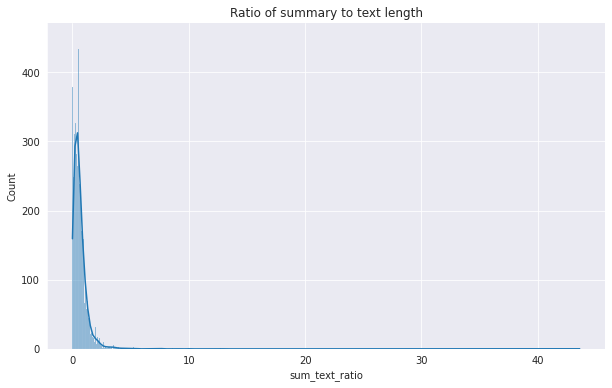

In [244]:
# lets see the graph again

sns.histplot(data['sum_text_ratio'], kde = True)
plt.title("Ratio of summary to text length")

In [245]:
# Such following examples cannot be summarized by just using the given text

# Text: 
# User: Pretty! 💙
# @browsercompany <STRICT_LINK>

# Summary:
# User: I'm not sure if I'm the only one who's having this issue, but I'm having a problem with the browserco app. I can't get it to open. I've tried restarting my phone, restarting the app, and even restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting m

# Text:
# User: @nick__pattison @figma That’s worrying.
# Summary:
# A user shared their DonorsChoose project for books about taking care of the Earth and suggested that students could use Figma's FigJam to collaborate on ideas and action plans based on their readings.

# Some summaries are not even related to the Text
# Text: 
# User: Why does @NotionHQ use a Somali domain?

# Summary:
# User is frustrated with the lack of updates on the Notion website and mentions that they have been waiting for a new feature for a long time.

# In some examples, the review doesn't look like it is of the mentioned product
# Text:
# User: Here’s an invite to Arc, the browser. Use it, you'll love it!
#arc @arcinternet <STRICT_LINK>
# Summary:
# User is excited about the new features in the latest version of Firefox, including the ability to create a new tab with a custom background and a new feature that allows users to create a new tab with a custom background and a new tab page.


# For a tweet to belong to the product, the product name has to be mentioned in the tweet. Or the mention (@). We can maybe check using this heuristic if the tweet even belongs to the product

# looking at some of the above texts, I believe the model will have less metric score on Twitter source.
print(list(data[data['sum_text_ratio'] > 2].index))

[62, 239, 242, 646, 753, 755, 997, 1003, 1018, 1162, 1224, 1309, 1387, 1414, 1433, 1464, 1497, 1549, 1688, 1719, 1752, 1758, 1847, 1901, 1923, 1945, 1954, 1957, 1959, 1967, 1972, 2013, 2028, 2036, 2041, 2058, 2072, 2074, 2081, 2129, 2141, 2158, 2175, 2186, 2187, 2194, 2231, 2254, 2258, 2296, 2299, 2308, 2318, 2352, 2359, 2383, 2386, 2390, 2396, 2405, 2414, 2415, 2423, 2442, 2445, 2451, 2472, 2483, 2494, 2504, 2517, 2518, 2524, 2533, 2546, 2556, 2596, 2607, 2644, 2648, 2669, 2680, 2694, 2698, 2701, 2702, 2704, 2706, 2714, 2755, 2779, 2793, 2799, 2821, 2831, 2861, 2867, 2873, 2892, 2893, 2911, 2924, 2936, 2942, 2944, 2956, 2962, 2979, 3090, 3112, 3221, 3335, 3375, 3411, 3446, 3457, 3485, 3521, 3552, 3569, 3649, 3672, 3695, 3705, 3754, 3762, 3862, 3897, 4074, 4143, 4169, 4388, 4402, 4412, 4461, 4475, 4490, 4499, 4525, 4535, 4543, 4604, 4614, 4622, 4631, 4637, 4647, 4686, 4700, 4727, 4840, 4913, 4979, 5001]


In [246]:
# even while reading some G2 text and summary, they dont seem related to each other. 

# Text:
# User: I use Figjam to get alignment on key initiatives and work through brainstorming sessions.
# User: Easy to use and flexible for all my needs.
# User: Can be hard to give access to others and sometimes it doesnt work

# Summary:
# Users appreciate Miro's ability to facilitate synchronous and asynchronous brainstorming, as well as its wide range of templates for visualizing ideas and requirements. However, they note that it requires a good internet connection and lacks features like hatched backgrounds, compared to lighter tools like Excalidraw.

# There are many instances like above

# lets find the semantic similarity between the summary and text. 
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer(model_for_embeddings)

def get_sim_score(row):
    #Compute embedding for both lists
    embeddings1 = model.encode(row["Text"], convert_to_tensor=True)
    embeddings2 = model.encode(row["Summary"], convert_to_tensor=True)
    #Compute cosine-similarities
    cosine_score = util.cos_sim(embeddings1, embeddings2)
    return cosine_score.item()

In [247]:
data['sim_score'] = data.apply(get_sim_score, axis = 1)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_27215/8843591.py:1 in <module>                                                    │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_27215/8843591.py'                           │
│                                                                                                  │
│ /home/admin/anaconda3/envs/beast/lib/python3.10/site-packages/pandas/core/frame.py:9433 in apply │
│                                                                                                  │
│    9430 │   │   │   args=args,                                                                   │
│    9431 │   │   │   kwargs=kwargs,                                                               │
│    9432 │   │   )                                                                                │
│ ❱  9433 │   │   return op.apply().__finalize__(self, method="apply")                             │
│    9434 │                                                                                        │
│    9435 │   def applymap(                                                                        │
│    9436 │   │   self, func: PythonFuncType, na_action: str | None = None, **kwargs               │
│                                                                                                  │
│ /home/admin/anaconda3/envs/beast/lib/python3.10/site-packages/pandas/core/apply.py:678 in apply  │
│                                                                                                  │
│    675 │   │   elif self.raw:                                                                    │
│    676 │   │   │   return self.apply_raw()                                                       │
│    677 │   │                                                                                     │
│ ❱  678 │   │   return self.apply_standard()                                                      │
│    679 │                                                                                         │
│    680 │   def agg(self):                                                                        │
│    681 │   │   obj = self.obj                                                                    │
│                                                                                                  │
│ /home/admin/anaconda3/envs/beast/lib/python3.10/site-packages/pandas/core/apply.py:798 in        │
│ apply_standard                                                                                   │
│                                                                                                  │
│    795 │   │   return result                                                                     │
│    796 │                                                                                         │
│    797 │   def apply_standard(self):                                                             │
│ ❱  798 │   │   results, res_index = self.apply_series_generator()                                │
│    799 │   │                                                                                     │
│    800 │   │   # wrap results                                                                    │
│    801 │   │   return self.wrap_results(results, res_index)                                      │
│                                                                                                  │
│ /home/admin/anaconda3/envs/beast/lib/python3.10/site-packages/pandas/core/apply.py:814 in        │
│ apply_series_generator                                                                           │
│                                                                                                  │
│    811 │   │   with option_context("mode.chained_assignment

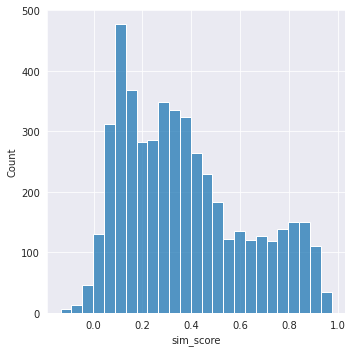

In [ ]:
sns.displot(data['sim_score'], kind = "hist")

In [ ]:
# need to replace "\n" with "None"
data[(data['sim_score'] < 0.2) & (data['Summary'] != "None") & (data['text_length'] > 4)]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score
2,Notion,Appstore/Playstore,User: Have you ever experienced this situation...,Nothing,20,1,0.050000,0.010165
8,Notion,Appstore/Playstore,User: I HAD SUCH A LONG NOTION PAGES AND MY AC...,Nothing,16,1,0.062500,0.118868
15,Notion,Appstore/Playstore,User: The only place to put your “Notes-On”,Nothing,8,1,0.125000,0.110216
25,Notion,Appstore/Playstore,"User: I love motion to plan my days, and write...",Nothing,12,1,0.083333,0.099988
30,Notion,Appstore/Playstore,User: My Apple Pencil can't work well with thi...,Nothing,10,1,0.100000,0.124181
...,...,...,...,...,...,...,...,...
4993,zoom,Appstore/Playstore,User: It's to cold 🥶,Nothing,5,1,0.200000,0.138788
4995,zoom,Appstore/Playstore,User: Vioalnl1 has also been linked 4AM,Nothing,7,1,0.142857,0.051569
4997,zoom,Appstore/Playstore,User: I will use this please install it please,Nothing,9,1,0.111111,0.023296
5002,zoom,Appstore/Playstore,User: If all human being be good for each othe...,Nothing,16,1,0.062500,0.104599


In [ ]:
data["Summary"] = data['Summary'].apply(lambda text: "Nothing" if text in ["\n", "none", "\nNone", "\nnone"] else text)

In [ ]:
# get indices with low sim score. 0.2 is just a parameter. Sometimes text says: "Great app" and the summary is a bit large, and sim_score gets low value. To avoid such indices in exploration, we keep text_length > 4
less_sim_scores_indices = data[(data['sim_score'] < 0.2) & (data['Summary'] != "Nothing") & (data['text_length'] > 4)].index

In [ ]:
print((list(less_sim_scores_indices)))
# manually looked into these samples. They summary and text really dont make sense. Will remove such indices from training set. Will keep in test set, but will calculate metrics separately for a range of sim_scores

[2, 8, 15, 25, 30, 39, 61, 63, 70, 71, 75, 77, 78, 81, 83, 84, 88, 91, 97, 104, 107, 108, 109, 111, 112, 117, 118, 122, 128, 141, 143, 151, 156, 164, 174, 177, 190, 194, 197, 201, 203, 209, 217, 237, 239, 250, 275, 279, 289, 290, 301, 307, 308, 314, 322, 326, 341, 348, 350, 366, 368, 381, 386, 388, 390, 400, 411, 414, 415, 419, 421, 423, 431, 455, 456, 461, 463, 464, 473, 484, 485, 496, 497, 503, 509, 515, 516, 535, 540, 545, 552, 560, 561, 563, 568, 571, 575, 576, 583, 596, 600, 605, 607, 609, 612, 616, 618, 620, 639, 642, 645, 653, 655, 656, 664, 689, 690, 700, 702, 705, 713, 714, 715, 720, 722, 723, 725, 726, 742, 744, 772, 784, 789, 794, 807, 835, 842, 853, 855, 856, 861, 871, 880, 882, 885, 889, 894, 905, 927, 935, 937, 957, 970, 973, 988, 998, 1000, 1019, 1031, 1039, 1045, 1046, 1047, 1049, 1050, 1051, 1058, 1079, 1080, 1088, 1117, 1138, 1145, 1162, 1165, 1174, 1189, 1191, 1196, 1198, 1199, 1210, 1231, 1232, 1245, 1250, 1253, 1256, 1258, 1261, 1273, 1279, 1283, 1288, 1290, 1306, 

In [ ]:
data.isna().sum()

Customer          0
Type              0
Text              0
Summary           0
text_length       0
summary_length    0
sum_text_ratio    0
sim_score         0
dtype: int64

In [ ]:
# when saving, "None" becomes Null
data['Summary'] = data['Summary'].apply(lambda summary: "Nothing" if summary == "None" else summary)

In [ ]:
# index the all_encoded text
# https://www.sbert.net/docs/pretrained_models.html#model-overview

In [ ]:
# split the dataset. There is no label or group to perform groupwise or stratified splitting. We could do stratified splitting based on binning of sim_score, but it won't matter much. So perform Random splitting

# shuffle the dataset
shuffled_data = data.sample(frac = 1, random_state=42).reset_index(drop = True)

shuffled_data['Text'] = shuffled_data['Text'].replace("NA", pd.NA)
shuffled_data['Text'] = shuffled_data['Text'].replace("", pd.NA)
shuffled_data = shuffled_data[shuffled_data['Text'].notnull()].reset_index(drop = True)

# shuffled_data.to_csv(f"{orig_csv_save_name}.csv")

In [ ]:
# take care of different language 
# run similarity to find most matching summary and text

#Eg: User noticed that the FigJam marker looks thick when changing its size and suggested that the nib should get less pointy.  ---> 410 Summary
# Just noticed that that FigJam marker be lookin thicc when you change its size  cc figma 
# miggi figma But but But the nib should get less pointy ---> 3311 Text match with each other
# from datasets import Dataset
# import datasets

# dataset = datasets.load_dataset("csv", data_files="data_v1.csv")['train']
# print(dataset.column_names)
# embeddings_dataset.add_faiss_index(column="Text")

In [ ]:
import datasets
from datasets import Dataset

dataset = Dataset.from_pandas(shuffled_data)

In [ ]:
len(dataset)

4816

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer(model_for_embeddings)

In [ ]:
embeddings_dataset = dataset.map(
    lambda x: {"embeddings_text": model.encode(x["Text"])}
)

Map:   0%|          | 0/4816 [00:00<?, ? examples/s]

In [ ]:
embeddings_dataset = embeddings_dataset.map(
    lambda x: {"embeddings_summary": model.encode(x["Summary"])}
)

Map:   0%|          | 0/4816 [00:00<?, ? examples/s]

In [ ]:
ds = datasets.DatasetDict()

ds['train'] = embeddings_dataset

print(ds)

ds.save_to_disk(orig_csv_save_name)

DatasetDict({
    train: Dataset({
        features: ['Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score', 'embeddings_text', 'embeddings_summary'],
        num_rows: 4816
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/4816 [00:00<?, ? examples/s]

In [ ]:
import datasets
from datasets import Dataset

embeddings_dataset = datasets.load_from_disk(orig_csv_save_name)['train']

In [ ]:
import numpy as np

embeddings_dataset = embeddings_dataset.with_format("np")


In [ ]:
embeddings_dataset = embeddings_dataset.map(lambda row: {"embeddings_text": row['embeddings_text'].reshape(-1)})
embeddings_dataset = embeddings_dataset.map(lambda row: {"embeddings_summary": row['embeddings_summary'].reshape(-1)})

Map:   0%|          | 0/4816 [00:00<?, ? examples/s]

Map:   0%|          | 0/4816 [00:00<?, ? examples/s]

#### Now we will try to index summary instead of text and for each text try to find the nearest neighbor. This is done because this is many to one problem

In [ ]:
# this is for indexing summary
embeddings_dataset.add_faiss_index(column="embeddings_summary")

  0%|          | 0/5 [00:00<?, ?it/s]

Dataset({
    features: ['Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score', 'embeddings_text', 'embeddings_summary'],
    num_rows: 4816
})

In [ ]:
data_with_NN = []
for idx, row in enumerate(embeddings_dataset):
    score, sample = embeddings_dataset.get_nearest_examples(
        "embeddings_summary", row['embeddings_text'], k=1
    )
    sample['current_summary'] = [row['Summary']]
    sample['current_text'] = [row['Text']]
    sample['new_sim_score'] = score
    data_with_NN.append(sample)

In [ ]:
df_with_NN = pd.DataFrame(data_with_NN)

In [ ]:
def get_item_from_list(row):
    for feat in row.keys():
        row[feat] = list(row[feat])[0]
    return row

In [ ]:
df_with_NN = df_with_NN.apply(get_item_from_list)

In [ ]:
df_with_NN[df_with_NN['current_summary'] == "Nothing"].sample(5)

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,current_summary,current_text,new_sim_score
662,Notion,Twitter,User: Got the much awaited @browsercompany Arc...,User is excited about the new @browsercompany ...,42,24,0.571429,0.824001,"[0.012039247, -0.03795843, 0.094289556, -0.028...","[-0.021330852, -0.08874916, 0.06713631, -0.031...",Nothing,User: If anyone is still looking for an invite...,0.604201
4489,Notion,Twitter,"User: ""how long have i spent playing around wi...",User is excited about the new features in the ...,22,20,0.909091,0.628983,"[0.016849698, -0.039888777, 0.057767563, 0.066...","[-0.026670497, -0.1081213, 0.045641348, 0.0143...",Nothing,User: @arcinternet could be my new favourite b...,0.538989
1632,Notion,Appstore/Playstore,User: Please fix the infinite loading problem.,User requests a fix for the infinite loading p...,7,9,1.285714,0.908581,"[-0.059018515, 0.023280252, -0.0051394696, -0....","[-0.10381718, -0.00727149, 0.00037356096, 0.00...",Nothing,User: It just keeps loading infinitely,0.39153
552,Notion,Appstore/Playstore,User: Haven't been in for a few days now.\nI s...,User is unable to access their saved data and ...,18,11,0.611111,0.526054,"[0.08507799, -0.010142047, -0.049421355, 0.012...","[0.03415595, 0.09136375, -0.085790604, -0.0263...",Nothing,User: Sss,1.195279
4249,figma,Twitter,"User: @Shark35Zulu @reidhoffman @figma ""her ap...",User discusses the benefits of using Figma and...,101,22,0.217822,-0.023577,"[0.02461741, 0.028953802, 0.04020809, 0.001788...","[-0.078941874, -0.017053321, 0.053934023, -0.0...",Nothing,User: Which is best to implement?\n@figma prot...,0.423403


In [ ]:
df_with_NN["Summary"] = df_with_NN["Summary"].replace("\n\n\nNone", "Nothing")

In [ ]:
# 161, 164, 

#3593 --> abnormals
print("Current Text: ", df_with_NN["current_text"][171])
print("Current Summary: ", df_with_NN["current_summary"][171])
print("New Summary: ", df_with_NN["Summary"][171])
print("Current score: ", df_with_NN['sim_score'][171])
print("New score: ", df_with_NN['new_sim_score'][171])

# If old sim_score > new score, then dont consider that Text
# if current summary is nothing and new score < 0.9, then let Nothing be the Summary
# take care of language in an experiment
# when text is small and current summary is nothing, then accept current summary

Current Text:  User: It's a great way make sure you if your secret space secrets
Current Summary:  Nothing
New Summary:  Users appreciate Figma's virtual collaboration features, templates, and versatility for meetings, trainings, and idea sharing. However, they find navigation and privacy settings challenging, especially when securing sensitive boards or spaces.
Current score:  0.45158827
New score:  1.1037991


In [ ]:
df_with_NN_to_save = df_with_NN[['current_text', 'Summary', 'Customer', 'Type']]
df_with_NN_to_save = df_with_NN_to_save.rename(columns={'current_text': 'Text'})

In [ ]:
df_with_NN_to_save['text_length'] = df_with_NN_to_save['Text'].apply(lambda text: len(text.split()))
df_with_NN_to_save['summary_length'] = df_with_NN_to_save['Summary'].apply(lambda summary: len(summary.split()))
df_with_NN_to_save['sum_text_ratio'] = df_with_NN_to_save['summary_length'] / df_with_NN_to_save['text_length']

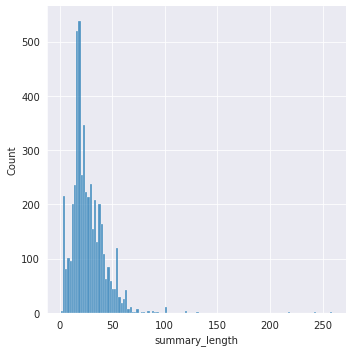

In [ ]:
sns.displot(df_with_NN_to_save['summary_length'])

In [ ]:
df_with_NN_to_save[df_with_NN_to_save['summary_length'] < 4]['Summary'].value_counts()

Summary
Error               2
User loves Zoom.    1
Name: count, dtype: int64

In [ ]:
df_with_NN_to_save[df_with_NN_to_save['Summary'] == "Nothing"]

,Text,Summary,Customer,Type,text_length,summary_length,sum_text_ratio


In [ ]:
df_with_NN_to_save['sim_score'] = df_with_NN_to_save.apply(get_sim_score, axis = 1)

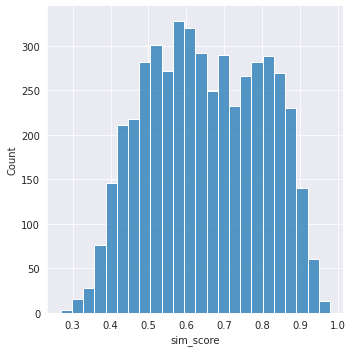

In [ ]:
# looks better than before
sns.displot(df_with_NN_to_save['sim_score'])

In [ ]:
# creating Dataset 

from datasets import Dataset, DatasetDict

df_with_NN_to_save.to_csv(f"{ann_csv_save_name}.csv", index = False)

# make 70-10-20 split for train/val/test
train_size = int(len(df_with_NN_to_save) * 0.7)
val_end_index = int(len(df_with_NN_to_save) * 0.8)
train_data = df_with_NN_to_save.loc[:train_size, :]
val_data = df_with_NN_to_save.loc[train_size:val_end_index :]
test_data = df_with_NN_to_save.loc[val_end_index: , :]
print(len(train_data), len(test_data))

trainds = Dataset.from_pandas(train_data)
valds = Dataset.from_pandas(val_data)
testds = Dataset.from_pandas(test_data)

ds = DatasetDict()

ds['train'] = trainds
ds['val'] = valds
ds['test'] = testds

print(ds)

ds.save_to_disk(ann_csv_save_name)

3372 964
DatasetDict({
    train: Dataset({
        features: ['Text', 'Summary', 'Customer', 'Type', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score'],
        num_rows: 3372
    })
    val: Dataset({
        features: ['Text', 'Summary', 'Customer', 'Type', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score'],
        num_rows: 482
    })
    test: Dataset({
        features: ['Text', 'Summary', 'Customer', 'Type', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score'],
        num_rows: 964
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/3372 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/482 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/964 [00:00<?, ? examples/s]

#### Now we will index text and find nearest neighbour for each summary

In [62]:
# this is for indexing text
embeddings_dataset.add_faiss_index(column="embeddings_text")

  0%|          | 0/5 [00:00<?, ?it/s]

Dataset({
    features: ['old_index', 'Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score', 'embeddings_text', 'embeddings_summary'],
    num_rows: 4754
})

In [63]:
data_with_NN = []
most_occuring_summaries = [
"User is excited about the new Notion app and is looking forward to using it."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
"User is excited about the new features in Notion and is looking forward to using them."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
"User is excited about the new features in the latest version of BrowserCO, including the ability to add a custom logo and customize the color of the logo."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
"User is excited about the new Notion features and is looking forward to using them."
]

for idx, row in enumerate(embeddings_dataset):
    num_nearest_neighbour = 1
    # if it is one of the most occuring summaries, then choose any one of the top 10 nearest neighbors. 
    if row['Summary'] in most_occuring_summaries:
        num_nearest_neighbour = 10
        random_index = np.random.choice(list(np.arange(10)))
    score, sample = embeddings_dataset.get_nearest_examples(
        "embeddings_text", row['embeddings_summary'], k=num_nearest_neighbour
    )
    if num_nearest_neighbour > 1:
        score = score[random_index]
        sample = sample[random_index]
    sample['nn_score_sum_text'] = score
    sample['nn_summary'] = [row['Summary']]
    data_with_NN.append(sample)


In [64]:
df_with_NN = pd.DataFrame(data_with_NN)

In [65]:
df_with_NN.head()

,old_index,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,nn_score_sum_text,nn_summary
0,[4072],[Notion],[Twitter],[3 Recommended Features of the NextGeneration ...,[User is excited about the new features in the...,[63],[47],[0.74603176],[0.51978576],"[[-0.05017201, -0.088704735, 0.044393152, -0.0...","[[-0.035239313, -0.08434058, -0.056149524, -0....",[0.65859526],[User is excited about the new features in the...
1,[4438],[Notion],[Appstore/Playstore],[The app does not currently work either on my ...,[Nothing],[19],[1],[0.05263158],[0.051373675],"[[-0.019981546, -0.10033529, 0.012108777, -0.1...","[[-0.020756068, -0.012999033, -0.015525485, 0....",[0.5451772],[User experienced issues with the app not work...
2,[926],[zoom],[Appstore/Playstore],[Zoom],[Nothing],[2],[1],[0.5],[0.18247163],"[[0.011151974, 0.020828238, -0.019462414, -0.0...","[[-0.020756068, -0.012999033, -0.015525485, 0....",[0.42996305],[User loves Zoom.]
3,[3858],[zoom],[Appstore/Playstore],[Nothing good Not bad],[Nothing],[5],[1],[0.2],[0.30265206],"[[-0.09590743, 0.023118168, -0.019100234, 0.02...","[[-0.020756068, -0.012999033, -0.015525485, 0....",[0.9370205],[Nothing]
4,[3858],[zoom],[Appstore/Playstore],[Nothing good Not bad],[Nothing],[5],[1],[0.2],[0.30265206],"[[-0.09590743, 0.023118168, -0.019100234, 0.02...","[[-0.020756068, -0.012999033, -0.015525485, 0....",[0.9370205],[Nothing]


In [66]:
def get_item_from_list(row):
    for feat in row.keys():
        row[feat] = list(row[feat])[0]
    return row

In [67]:
df_with_NN = df_with_NN.apply(get_item_from_list)

In [69]:
# we see that the summary in "nn_summary" is more related to Text than the GT "Summary". 
df_with_NN.sample(5)

,old_index,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,nn_score_sum_text,nn_summary
1658,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
2774,4198,Notion,Twitter,Im over here watching apple users use Arc by b...,User is excited about the new features in the ...,28,24,0.857143,0.558354,"[-0.024338316, -0.13424903, 0.0777007, -0.0971...","[-0.07026725, -0.05485882, -0.044097513, -0.05...",0.82396,User is excited about the new Notion for MacO...
4731,3128,Notion,Twitter,The kind of new features that browsercompany p...,User is excited about the new features in the ...,17,18,1.058824,0.701903,"[-0.045748383, -0.05843747, 0.010421868, -0.01...","[-0.073257014, -0.04682944, -0.063241355, -0.0...",0.757194,User is excited about the new features in the ...
869,3668,figma,Twitter,What do you think about this I took everyones ...,Nothing,71,1,0.014085,0.052437,"[-0.0035923666, 0.008641695, 0.031736176, -0.0...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.638973,User redesigned a project in Figma based on a...
4383,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing


In [72]:
# for "Nothing", we see that the "Text" is always the same. So when the "nn_summary" is "Nothing" then match it randomly with some Text that is not closest neighbour to any of the "Summary". This is done to maintain diversity.
# if not "Nothing", then compare the sim_scores and then decide which to pick based on that

df_with_NN[df_with_NN['nn_summary'] == "Nothing"]

,old_index,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,nn_score_sum_text,nn_summary
3,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
5,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
15,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
16,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4733,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4739,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4741,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4749,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing


In [74]:
old_indices_in_nn = list(df_with_NN['old_index'].values)
all_old_indices = list(df_with_NN.index)

old_indices_not_occuring_in_nn = [idx for idx in all_old_indices if idx not in old_indices_in_nn]

In [77]:
# due to nearest neighbour approach, too many Text got rejected. Need to have another strategy because this is many-to-one problem statement (for many Text there can be 1 Summary)
len(old_indices_not_occuring_in_nn)

3188

In [82]:
# sample randomly from old_indices_not_occuring_in_nn if "Nothing" occurs in "nn_summary"
for idx, row in df_with_NN.iterrows():
    if row['nn_summary'] == "Nothing":
        random_idx = np.random.choice(old_indices_not_occuring_in_nn)
        text = dataset[int(random_idx)]['Text']
        print("Before: ", df_with_NN.loc[idx, 'Text'])
        df_with_NN.loc[idx, 'Text'] = text
        print("After: ", df_with_NN.loc[idx, 'Text'])
    else:
        # compare the similarity scores and take the Text or take the original Text
        nn_sim_score = float(row['nn_score_sum_text'])
        sim_score = float(row['sim_score'])
        # if nn simscore is lesser, then keep the original Text for this summary
        if nn_sim_score < sim_score:
            text = dataset[int(idx)]['Text']
            df_with_NN.loc[idx, 'Text'] = text

Before:  Nothing good Not bad
After:  Just did a visual experiment using midjourney and figma
Poster Inspired from FonsMans 
0xMayankSingh midjourney figma FonsMans 
msk_web_ midjourney figma FonsMans 
Before:  Nothing good Not bad
After:  Like 
Before:  Nothing good Not bad
After:  The moment I saw this design from druids01 sometimes in 2022 I told myself I was going to redesign it no matter how long it takes me after months of procrastination then finally started the design in April and then to prototyping
Heres what I came up with  
OfficialSirEmmy stephanieorkuma druids01 figma bamtickDA Love the interactions  
Well done boss
taofeeq_uiux stephanieorkuma druids01 figma bamtickDA Thank you boss
Before:  Nothing good Not bad
After:  Ive definitely moved on to brave Goodbye googlechrome of the balls
The great battle iOS VS Android has begun
I use iPhone but damn Apple too
Final Boss Adsense monetize with another platform 
fdefree_ brave googlechrome Im waiting for browsercompany to re

In [83]:
df_with_NN.head()

,old_index,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,nn_score_sum_text,nn_summary
0,4072,Notion,Twitter,3 Recommended Features of the NextGeneration B...,User is excited about the new features in the ...,63,47,0.746032,0.519786,"[-0.05017201, -0.088704735, 0.044393152, -0.01...","[-0.035239313, -0.08434058, -0.056149524, -0.0...",0.658595,User is excited about the new features in the ...
1,4438,Notion,Appstore/Playstore,The app does not currently work either on my i...,Nothing,19,1,0.052632,0.051374,"[-0.019981546, -0.10033529, 0.012108777, -0.10...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.545177,User experienced issues with the app not worki...
2,926,zoom,Appstore/Playstore,Zoom,Nothing,2,1,0.5,0.182472,"[0.011151974, 0.020828238, -0.019462414, -0.04...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.429963,User loves Zoom.
3,3858,zoom,Appstore/Playstore,Just did a visual experiment using midjourney ...,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4,3858,zoom,Appstore/Playstore,Like,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing


In [84]:
# all the ones which have same nn_summary, will have same Text because of the nearest neighbour approach. Need to take care of that
df_with_NN['nn_summary'].value_counts()

nn_summary
Nothing                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [86]:
df_with_NN_to_save = df_with_NN[["Customer", "Type", "Text", "nn_summary"]]
df_with_NN_to_save = df_with_NN_to_save.rename(columns={"nn_summary": "Summary"})

In [87]:
df_with_NN_to_save['text_length'] = df_with_NN_to_save['Text'].apply(lambda text: len(text.split()))
df_with_NN_to_save['summary_length'] = df_with_NN_to_save['Summary'].apply(lambda summary: len(summary.split()))
df_with_NN_to_save['sum_text_ratio'] = df_with_NN_to_save['summary_length'] / data['text_length']

In [88]:
df_with_NN_to_save['sim_score'] = df_with_NN_to_save.apply(get_sim_score, axis = 1)

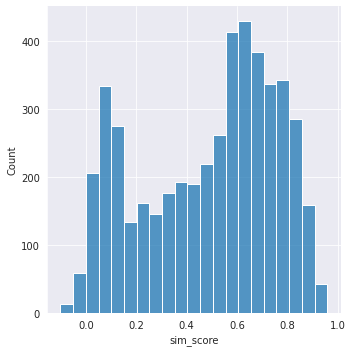

In [90]:
# the plot is looks better than before. The high bars are greater than 0.5 atleast with some at 0.1. Maybe we can neglect those for training?
sns.displot(df_with_NN_to_save['sim_score'], kind = "hist")

In [99]:
# all Summary are Nothing. Need to be treated better.
df_with_NN_to_save[df_with_NN_to_save['sim_score'] < 0.15]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score
3,zoom,Appstore/Playstore,Just did a visual experiment using midjourney ...,Nothing,21,1,0.017857,0.073340
5,zoom,Appstore/Playstore,The moment I saw this design from druids01 som...,Nothing,67,1,0.007812,0.063376
15,zoom,Appstore/Playstore,Ive definitely moved on to brave Goodbye googl...,Nothing,58,1,0.125000,0.076006
16,zoom,Appstore/Playstore,Which notetaking app works similar to RoamRese...,Nothing,119,1,0.007576,-0.003354
18,zoom,Appstore/Playstore,arcinternet _adenab done \nIm curious theres p...,Nothing,139,1,0.333333,0.084438
...,...,...,...,...,...,...,...,...
4733,zoom,Appstore/Playstore,my mom said i should bring business cards to C...,Nothing,16,1,0.500000,0.001646
4739,zoom,Appstore/Playstore,Did you see the the ShortList for Work Coordin...,Nothing,23,1,0.333333,0.005955
4741,zoom,Appstore/Playstore,It makes it easy for my clients to visualize w...,Nothing,64,1,0.333333,0.071782
4749,zoom,Appstore/Playstore,browsercompany these pinned tabs hovering on a...,Nothing,31,1,0.166667,0.077296


In [100]:
# some low sim scores with non-Nothing summary
df_with_NN_to_save[(df_with_NN_to_save['sim_score'] < 0.15) & (df_with_NN_to_save['Summary'] != "Nothing")]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score
72,Notion,Appstore/Playstore,arcinternet _adenab Every time we do these we ...,User is frustrated with the lack of updates on...,52,17,0.151786,0.133726
289,figma,Twitter,I constantly get this error using figma mirror...,User suggests adding a text curve feature in F...,42,18,0.545455,0.142487
341,figma,Twitter,Up your gradient game \nLearn how to create th...,User is optimistic about AI's ability to ampl...,270,23,2.555556,0.085729
434,figma,Twitter,I work a 95 and run a freelance design busines...,Celebrating educators in the Figma for Edu com...,127,12,6.000000,0.105976
573,figma,Twitter,Teachers We have lots of DonorsChoose funding ...,User noticed that the FigJam marker looks thic...,84,21,0.750000,0.142247
592,figma,Twitter,Since biology is trendinglet me introduce myse...,User suggests a feature to restore previous ve...,46,17,0.246377,-0.030410
597,figma,Twitter,How to turn an almost perfect UIUX to perfect...,Celebrating educators in the Figma for Edu com...,270,12,0.461538,0.091562
966,figma,Twitter,If I have a frame set to be fixed on scroll I ...,User is disappointed with the lack of exportin...,156,56,0.394366,-0.045667
1035,figma,Twitter,This on figma makes no sense Who decided rgba ...,The user is asking for support to get their pr...,37,25,0.462963,0.144264
1094,figma,Twitter,RT zeealeid Announcing an update to Windows 11...,A user shares their appreciation for the oppor...,21,26,0.325000,0.087807


In [101]:
print("Text: ", df_with_NN_to_save['Text'][4681])
print("Summary: ", df_with_NN_to_save['Summary'][4681])

Text:  Working a boring job is difficult Owning a business is difficult Making time for your NotionHQ
side hustle is difficult Being in poverty is difficult Its up to you which difficult thing you go for Choose wisely
Summary:  User is excited about the new Notion app and is looking forward to using it.


In [102]:
df_with_NN_to_save.to_csv("data_v3_with_ann.csv", index = False)

In [103]:
# creating Dataset 

from datasets import Dataset, DatasetDict


train_size = int(len(df_with_NN_to_save) * 0.8)
train_data = df_with_NN_to_save.loc[:train_size, :]
test_data = df_with_NN_to_save.loc[train_size: , :]
print(len(train_data), len(test_data))

tds = Dataset.from_pandas(train_data)
testds = Dataset.from_pandas(test_data)

ds = DatasetDict()

ds['train'] = tds
ds['test'] = testds

print(ds)

ds.save_to_disk('data_v3')

3804 951
DatasetDict({
    train: Dataset({
        features: ['Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score'],
        num_rows: 3804
    })
    test: Dataset({
        features: ['Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score'],
        num_rows: 951
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/3804 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/951 [00:00<?, ? examples/s]